In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *

In [4]:
DATA = Path('data')
NSYNTH_AUDIO = DATA/'nsynth_audio' # contains train and valid folders

In [5]:
LABEL_DIR = Path('tmp_labels')
GUITAR_TRN = LABEL_DIR/'train_guitar_clean_40_88.csv'
GUITAR_VAL = LABEL_DIR/'valid_guitar_clean_40_88.csv'
GUITAR_TST = LABEL_DIR/'test_guitar_clean_40_88.csv'

In [6]:
trn_df, val_df, tst_df = [pd.read_csv(CSV) for CSV in [GUITAR_TRN, GUITAR_VAL, GUITAR_TST]]
trn_df.head(2)

,note_str,pitch
0,guitar_acoustic_001-082-050,82
1,guitar_electronic_035-062-127,62


In [7]:
len(trn_df), len(val_df), len(tst_df)

(16915, 1112, 347)

In [8]:
trn_list, val_list, tst_list = [AudioItemList.from_df(df, path=NSYNTH_AUDIO, 
                                                      folder=folder, suffix='.wav')
                                for df, folder in zip([trn_df, val_df, tst_df], 
                                                      ['train', 'valid', 'test'])]
len(trn_list), len(val_list), len(tst_list)

(16915, 1112, 347)

In [34]:
torch.hann_window(1024).unsqueeze_(0)

tensor([[0.0000e+00, 9.4175e-06, 3.7640e-05,  ..., 8.4698e-05, 3.7640e-05,
         9.4175e-06]])

In [88]:
to_db = ToDecibels(ref=1.0, top_db=50.0)
window = to_device(torch.hann_window(1024).unsqueeze_(0), None)

def get_frame(x, start=1024, frame_len=1024):
    return x[start:start+frame_len]

def batch_fft(inputs):
    xs, ys = inputs
    xs = torch.rfft(xs * window, 1, normalized=True).pow_(2.0).sum(-1)
    xs = to_db(xs)
    return xs, ys


In [89]:
# to_db = ToDecibels(ref=1.0, top_db=50.0)

In [90]:
# n_fft = 512 
# n_hop = 256
# n_mels = 64
# sample_rate = 16000
# ref = 'max'
# top_db = 50.0

bs = 32

tfm_list = [get_frame]
tfms = (tfm_list, tfm_list) # train, valid tfms 

batch_tfms = [batch_fft]

data = (ItemLists(NSYNTH_AUDIO, trn_list, val_list)
            .label_from_df('pitch')
            .add_test(tst_list)
            .transform(tfms)
            .databunch(bs=bs, tfms=batch_tfms))
xs, ys = data.one_batch()
xs.shape, ys.shape, xs.min(), xs.max()

(torch.Size([32, 513]), torch.Size([32]), tensor(-0.4000), tensor(1.3257))

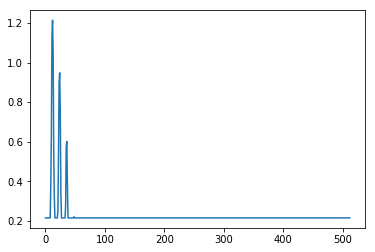

In [91]:
# plt.plot(xs[0])

In [121]:
class SimpleModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.layers = nn.Sequential(
            *bn_drop_lin(513, 1024, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(1024, 128, actn=nn.ReLU(inplace=True), p=0.2),
            *bn_drop_lin(128, n_classes, actn=None, p=0.2),
        )
    def forward(self, x):
        return self.layers(x)

In [122]:
model = SimpleModel(data.c)
learn = Learner(data, model, metrics=[accuracy])
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [32, 513]            1026       True      
______________________________________________________________________
Dropout              [32, 513]            0          False     
______________________________________________________________________
Linear               [32, 1024]           526336     True      
______________________________________________________________________
ReLU                 [32, 1024]           0          False     
______________________________________________________________________
BatchNorm1d          [32, 1024]           2048       True      
______________________________________________________________________
Dropout              [32, 1024]           0          False     
______________________________________________________________________
Linear               [32, 128]            131200     True      
______________________________________________________________

In [123]:
model_name = 'pitch_frame_v1'
learn.fit_one_cycle(4)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,0.662265,0.075000,0.995504
2,0.402710,0.012694,0.999101
3,0.331643,0.004971,1.000000
4,0.254071,0.003923,1.000000


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


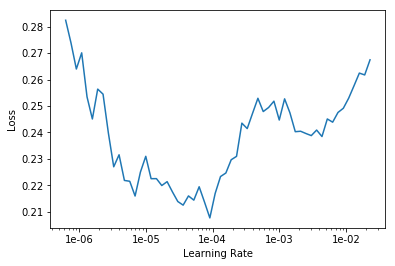

In [124]:
learn.load(model_name + '-stage-1')
learn.lr_find()
learn.recorder.plot()

In [125]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=1e-4)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy
1,0.237514,0.004158,1.000000
2,0.246843,0.003731,1.000000
3,0.223726,0.003049,1.000000
4,0.231029,0.003068,1.000000
5,0.226537,0.003267,1.000000
6,0.209286,0.002676,1.000000
7,0.202147,0.002739,1.000000
8,0.237993,0.002835,1.000000


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


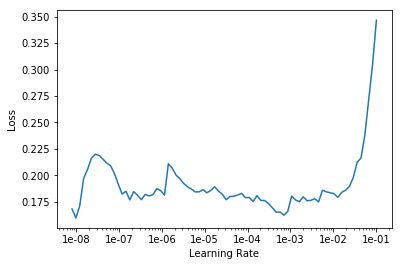

In [126]:
learn.load(model_name + '-stage-2')
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [127]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(8, max_lr=1e-5)
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,accuracy
1,0.214286,0.002846,1.000000
2,0.235842,0.002893,1.000000
3,0.206068,0.003207,1.000000
4,0.203597,0.002949,1.000000
5,0.217814,0.003007,1.000000
6,0.207101,0.002995,1.000000
7,0.196428,0.002910,1.000000
8,0.209104,0.002992,1.000000


In [128]:
def preds_stats(learner):
    trn_accuracy = float(accuracy(*learner.get_preds(DatasetType.Train)))
    trn_error_rate = 1 - trn_accuracy
    trn_errors = round(len(learner.data.train_ds) * trn_error_rate)
    
    val_accuracy = float(accuracy(*learner.get_preds(DatasetType.Valid)))
    val_error_rate = 1 - val_accuracy
    val_errors = round(len(learner.data.valid_ds) * val_error_rate)
    
    print("Train\n-----")
    print("  accuracy:   {:.4f}".format(trn_accuracy))
    print("  num_errors: {}".format(trn_errors))
    
    
    print("Valid\n-----")
    print("  accuracy:   {:.4f}".format(val_accuracy))
    print("  num_errors: {}".format(val_errors))
    
preds_stats(learn)

Train
-----
  accuracy:   0.9722
  num_errors: 471
Valid
-----
  accuracy:   1.0000
  num_errors: 0


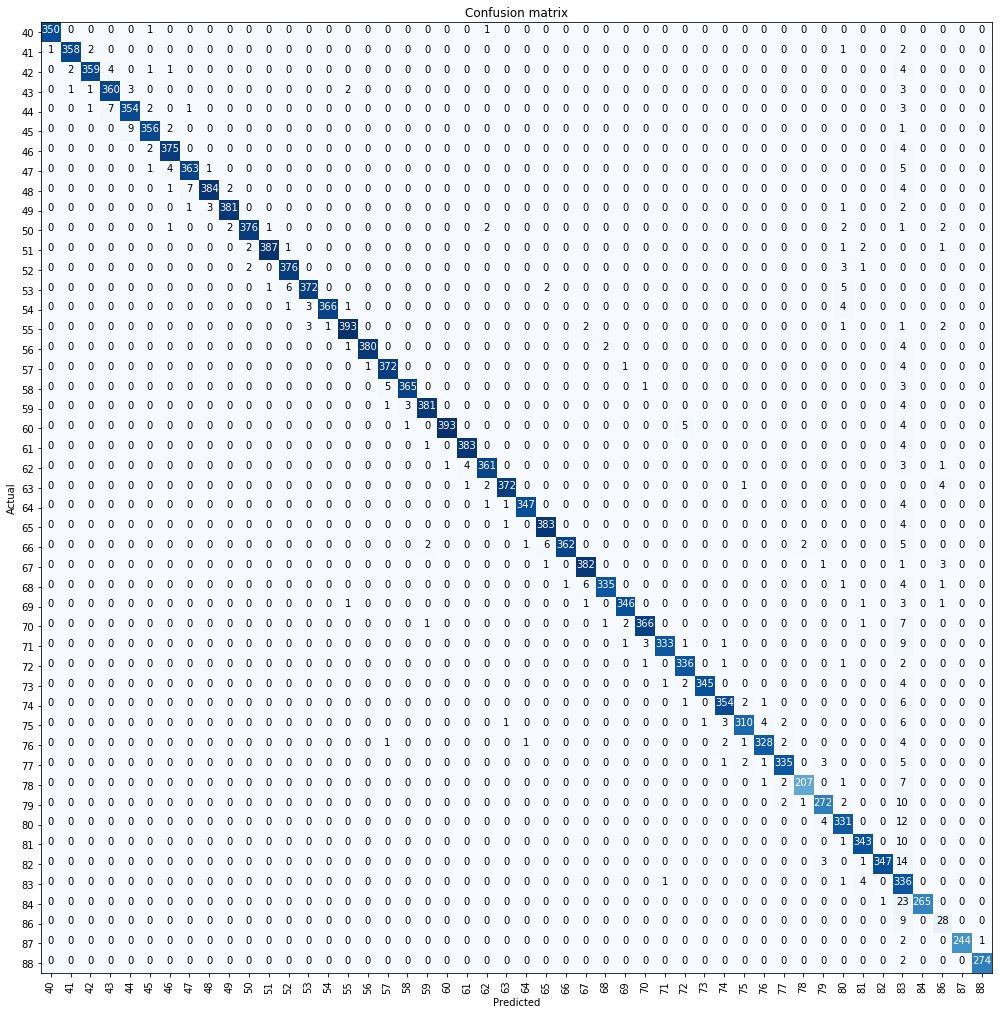

In [129]:
interp = learn.interpret(DatasetType.Train)
interp.plot_confusion_matrix(figsize=(14, 14))

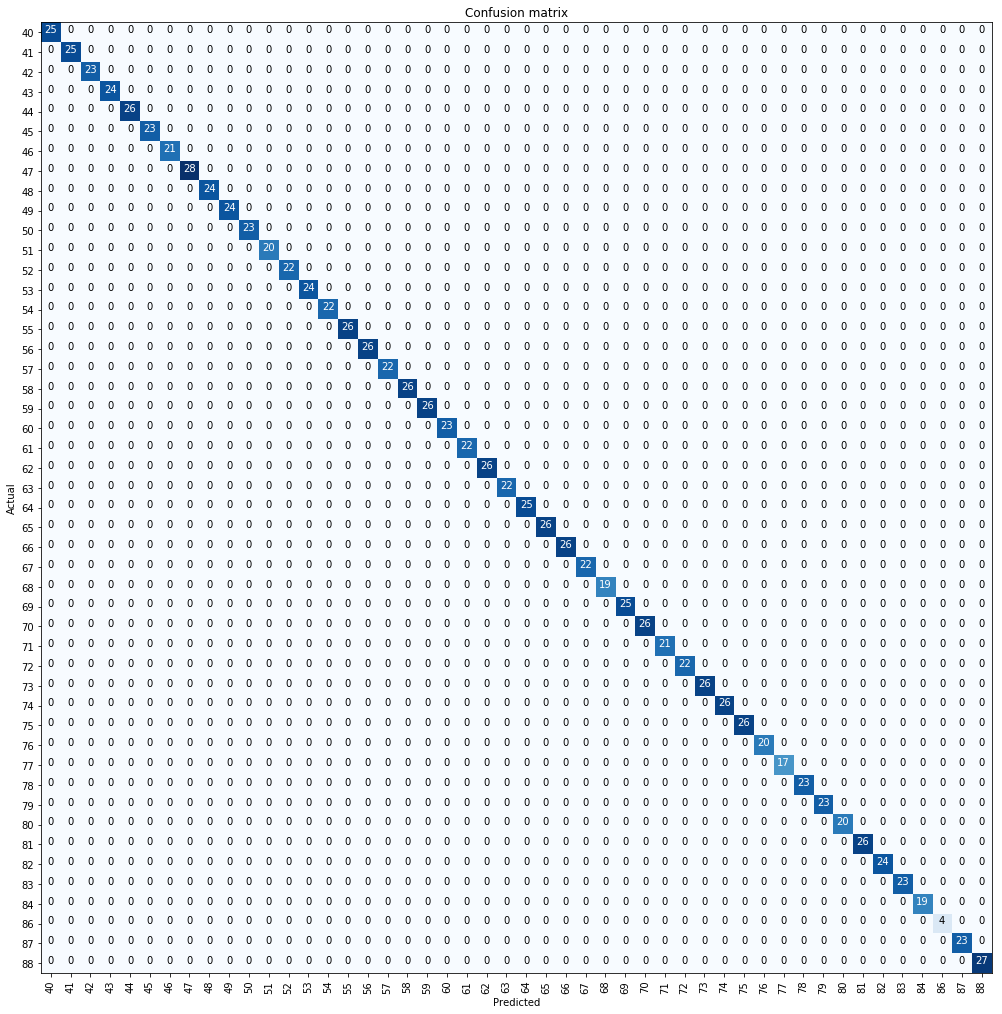

In [130]:
interp = learn.interpret(DatasetType.Valid)
interp.plot_confusion_matrix(figsize=(14, 14))

In [131]:
model = SimpleModel(data.c)
learn = Learner(data, model, metrics=[accuracy])
model_name = 'pitch_frame_100_epochs'
learn.fit_one_cycle(100)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy
1,1.843367,1.177452,0.994604
2,0.897136,0.318304,0.994604
3,0.558286,0.099122,0.995504
4,0.421805,0.045881,0.995504
5,0.395579,0.029573,0.999101
6,0.346839,0.019082,1.000000
7,0.358281,0.014018,0.999101
8,0.336799,0.010575,1.000000
9,0.320674,0.012847,0.999101
10,0.295660,0.003940,1.000000


In [132]:
preds_stats(learn)

Train
-----
  accuracy:   0.9832
  num_errors: 284
Valid
-----
  accuracy:   1.0000
  num_errors: 0
